# Transformación inversa de Yeo-Johnson


Función en `Python` para calcular la **transformación inversa de Yeo-Johnson** a partir del valor de $\lambda$ y el valor transformado $x'$. Es decir, permite obtener el valor original $x$ dado $x'$.

**Transformación de Yeo-Johnson:**

$$
x' = \begin{cases}
\dfrac{(x+1)^{\lambda}-1}{\lambda}, & x \geq 0,\ \lambda \neq 0 \\[6pt]
\ln(x+1), & x \geq 0,\ \lambda = 0 \\[6pt]
-\dfrac{(-x+1)^{2-\lambda}-1}{2-\lambda}, & x < 0,\ \lambda \neq 2 \\[6pt]
-\ln(-x+1), & x < 0,\ \lambda = 2
\end{cases}
$$


In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import yeojohnson

import matplotlib.pyplot as plt
plt.style.use('toutl.mplstyle')
from style import *

Despejando la variable original $x$ a partir de la variable transformada $x′$, se obtiene la expresión de la **inversa de la transformación Yeo-Johnson**:

$$
x = \begin{cases}
(\lambda x'+1)^{1/\lambda}-1, & x' \geq 0,\ \lambda \neq 0 \\[6pt]
e^{x'} - 1, & x' \geq 0,\ \lambda = 0 \\[6pt]
1-[1-(2-\lambda)x']^{1/(2-\lambda)}, & x' < 0,\ \lambda \neq 2 \\[6pt]
-(e^{-x'}-1), & x' < 0,\ \lambda = 2
\end{cases}
$$

***Forma Equivalente de la Inversa Yeo-Johnson** (Optimizada para Computación)*

Una versión algebraicamente equivalente de la inversa de Yeo-Johnson, útil para ciertas implementaciones numéricas:

$$
x = \begin{cases}
e^{\frac{\ln(\lambda x'+1)}{\lambda}}-1, & x'\geq 0,\ \lambda \neq 0 \\[6pt]
e^{x'}-1, & x' \geq 0,\ \lambda = 0 \\[6pt]
-\left(e^{\frac{\ln(x'(\lambda-2)+1)}{2-\lambda}}-1\right), & x' < 0,\ \lambda \neq 2 \\[6pt]
-(e^{-x'}-1), & x' < 0,\ \lambda = 2
\end{cases}
$$

In [2]:
def inv_yeojohnson(y:np.ndarray,lmbda:float)->np.ndarray|None:
    """
    The Inverse Yeo-Johnson transform is given by:
        x = (lmbda * y + 1)**(1 / lmbda) - 1,              for y >= 0, lmbda != 0
            e**y - 1,                                      for y >= 0, lmbda = 0
            1 - (1 - (2 - lmbda) * y)**(1 / (2 - lmbda)),  for y < 0, lmbda != 2
            -(e**(-y) - 1),                                for y < 0, lmbda = 2
    Returns NaN for invalid operations.
    """
    y=np.asarray(y)
    # x=np.zeros_like(y)
    x=np.full_like(y,np.nan)
    pos=y>=0
    neg=~pos
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # y>=0
        if lmbda!=0:
            valid=(lmbda*y[pos]+1)>0
            x[pos]=np.where(valid,
                            np.expm1(np.log1p(lmbda*y[pos])/lmbda),
                            np.nan)

            # Fallback to original expression if numerical error
            if lmbda<0:
                fallback_valid=(lmbda*y[pos]+1)>0
                x[pos]=np.where(valid,
                                x[pos],
                                np.where(fallback_valid,
                                         (lmbda*y[pos]+1)**(1/lmbda)-1,
                                         np.nan))
        else:  # lmbda==0
            x[pos]=np.expm1(y[pos])
        
        # y<0
        if lmbda!=2:
            valid=(1-(2-lmbda)*y[neg])>0
            x[neg]=np.where(valid,
                             1-np.exp(np.log1p((lmbda-2)*y[neg])/(2-lmbda)),
                             np.nan)

            # Fallback to original expression if numerical error
            if lmbda>2:
                fallback_valid=(1-(2-lmbda)*y[neg])>0
                x[neg]=np.where(valid,
                                 x[neg],
                                 np.where(fallback_valid,
                                          1-(1-(2-lmbda)*y[neg])**(1/(2-lmbda)),
                                          np.nan))
        else:  # lmbda==2
            x[neg]=-np.expm1(-y[neg])
    
    return x

Gráfica de la familia de curvas para distintos valores de $\lambda$, utilizando un vector de valores en el intervalo $x'\in(-1,1)$.

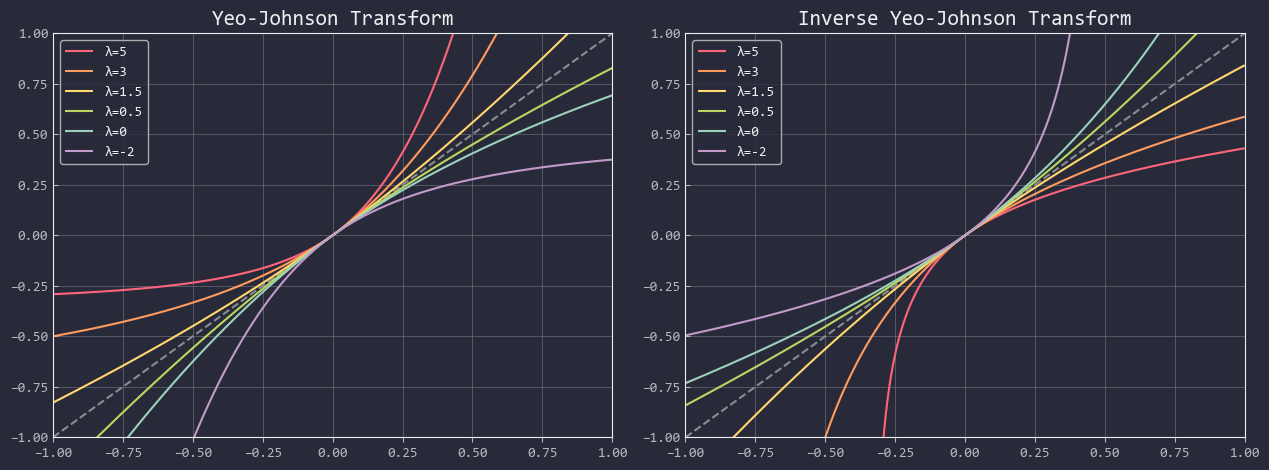

In [3]:
x=np.linspace(-1,1,700)
lambdas=[5,3,1.5,0.5,0,-2]

fig,axes=plt.subplots(1,2,figsize=(12.8,4.8))

for ax,func,title in zip(axes,(yeojohnson,inv_yeojohnson),('',"Inverse ")):
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.plot(x,x,'--',color=GY)
    
    for lmbd in lambdas:
        ax.plot(x,func(x,lmbd),label=f'λ={lmbd}')
    
    ax.set_title(f"{title}Yeo-Johnson Transform")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show();

**Verificación de la inversa:** aplicamos la transformación Yeo-Johnson y luego su inversa para comprobar que se recuperan los valores originales.

In [4]:
x=np.linspace(0,1,500)
display(x[0:20])
display(inv_yeojohnson(yeojohnson(x,-2),-2)[0:20])

array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603,
       0.01002004, 0.01202405, 0.01402806, 0.01603206, 0.01803607,
       0.02004008, 0.02204409, 0.0240481 , 0.0260521 , 0.02805611,
       0.03006012, 0.03206413, 0.03406814, 0.03607214, 0.03807615])

array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603,
       0.01002004, 0.01202405, 0.01402806, 0.01603206, 0.01803607,
       0.02004008, 0.02204409, 0.0240481 , 0.0260521 , 0.02805611,
       0.03006012, 0.03206413, 0.03406814, 0.03607214, 0.03807615])